In [3]:
import tensorflow as tf
print(tf.__version__)

2.17.0


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [2]:
# Build the model
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense_1 = Dense(64, activation='relu')
        self.dense_2 = Dense(10)
        self.dropout = Dropout(0.4)

    def call(self, inputs, training=True):
        x = self.dense_1(inputs)
        if (training):
            x = self.dropout(x)
        return self.dense_2(x)



In [3]:
# Print the model summary

model = MyModel()
model(tf.random.uniform([1, 10]))
model.summary()

NameError: name 'tf' is not defined

***
<a id="coding_tutorial_2"></a>
## Custom layers

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [ ]:
# Create a custom layer

class MyLayer(Layer):

    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal'),
        self.b = self.add_weight(shape=(units, ),
                                 initializer='zeros')

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

dense_layer = MyLayer(3, 5)
x = tf.ones((1, 5))
print(dense_layer(x))
print(dense_layer.weights)

In [ ]:
# Specify trainable weights

class MyLayer(Layer):

    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal',
                                trainable=False),
        self.b = self.add_weight(shape=(units, ),
                                 initializer='zeros')

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

dense_layer = MyLayer(3, 5)

In [ ]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 1
non-trainable weights: 1


In [ ]:
# Create a custom layer to accumulate means of output values

class MyLayerMean(Layer):

    def __init__(self, units, input_dim):
        super(MyLayerMean, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal')
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros')

        self.sum_activation = tf.Variable(initial_value=tf.zeros((units,)),
                                          trainable=False)
        self.number_call = tf.Variable(initial_value=0,
                                       trainable=False)

    def call(self, inputs):
        activations = tf.matmul(inputs, self.w) + self.b

        self.sum_activation.assign_add(tf.reduce_sum(activations, axis=0))
        self.number_call.assign_add(inputs.shape[0])

        mean_activation = self.sum_activation / tf.cast(self.number_call, tf.float32)
        return activations, mean_activation

dense_layer = MyLayerMean(3, 5)


In [ ]:
# Test the layer

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

[ 0.00929664 -0.11037041 -0.18607175]


In [ ]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate

    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)

#### Implement the custom layers into a model

In [ ]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()

    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)


***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

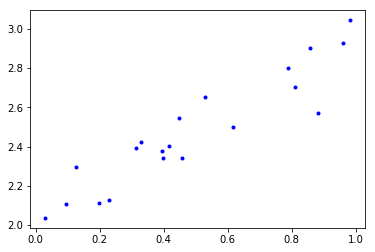

In [ ]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [ ]:
from tensorflow.keras.layers import Layer

In [ ]:
# Build a custom layer for the linear regression model

class LinearLayer(Layer):

    def __init__(self):
        super(LinearLayer, self).__init__()
        self.m = self.add_weight(shape=(1,),
                                initializer='random_normal')
        self.b = self.add_weight(shape=(1,),
                                initializer='zeros')

    def call(self, inputs):
        return self.m*inputs+self.b

linear_regression = LinearLayer()

print(linear_regression(x_train))
print(linear_regression.weights)

tf.Tensor(
[-1.0082419e-03 -2.9438786e-04 -1.2264183e-03 -3.8819370e-04
 -7.0066744e-04 -2.4949214e-03 -1.3783603e-03 -3.0209552e-03
 -2.9566381e-03 -2.7113876e-03 -1.2859150e-03 -9.1892944e-05
 -1.8978363e-03 -1.6290963e-03 -2.6417784e-03 -2.4218054e-03
 -9.6191443e-04 -6.0320576e-04 -1.2098387e-03 -1.4067909e-03], shape=(20,), dtype=float32)
[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-0.00307876], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


#### Define the loss function

In [ ]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true))

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 6.2394514


#### Train and plot the model

In [ ]:
# Implement a gradient descent training loop for the linear regression model

learning_rate = 0.5
steps=25

for i in range(steps):

    with tf.GradientTape() as tape:
        predictions = linear_regression(x_train)
        loss = SquaredError(predictions, y_train)

    gradients = tape.gradient(loss, linear_regression.trainable_variables)

    linear_regression.m.assign_sub(learning_rate * gradients[0])
    linear_regression.b.assign_sub(learning_rate * gradients[1])

    print('Step %d, Loss %f' % (i, loss.numpy()))

Step 0, Loss 1.222745
Step 1, Loss 1.060032
Step 2, Loss 0.923095
Step 3, Loss 0.804294
Step 4, Loss 0.700980
Step 5, Loss 0.611115
Step 6, Loss 0.532948
Step 7, Loss 0.464957
Step 8, Loss 0.405816
Step 9, Loss 0.354374
Step 10, Loss 0.309628
Step 11, Loss 0.270706
Step 12, Loss 0.236852
Step 13, Loss 0.207404
Step 14, Loss 0.181789
Step 15, Loss 0.159509
Step 16, Loss 0.140129
Step 17, Loss 0.123272
Step 18, Loss 0.108609
Step 19, Loss 0.095855
Step 20, Loss 0.084761
Step 21, Loss 0.075111
Step 22, Loss 0.066718
Step 23, Loss 0.059417
Step 24, Loss 0.053066


m:1,  trained m:[1.5529741]
b:2,  trained b:[1.6921495]


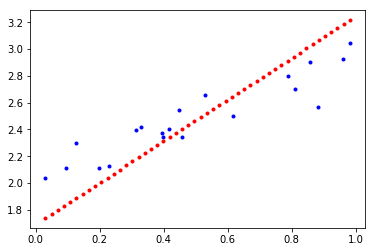

In [ ]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression.m.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression.m*x_linear_regression+linear_regression.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [65]:
# Define the custom layers and model
class MyLayer(Layer):

    def __init__(self, units):
        super(MyLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                name='kernel')
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros', name='bias')

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate

    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)


class MyModel(Model):

    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3)
        self.softmax = Softmax()

    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)

model = MyModel(64, 64, 46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.02394869 0.02732314 0.01692355 0.04807384 0.08947808 0.06513122
  0.01958008 0.00758906 0.03239644 0.00655914 0.00891811 0.05662281
  0.06321742 0.0034458  0.00386518 0.0083203  0.00361869 0.01454102
  0.00751162 0.02627831 0.00952047 0.00362751 0.01869664 0.01393329
  0.00722118 0.03617491 0.02502776 0.00548548 0.01883951 0.03533705
  0.01206535 0.01471736 0.05448157 0.02025549 0.00487272 0.03979075
  0.00911372 0.01438662 0.01024547 0.00066104 0.01013399 0.00344889
  0.00690536 0.07355576 0.01074889 0.00741077]], shape=(1, 46), dtype=float32)


Model: "my_model_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ my_layer_30 (MyLayer)                │ ?                           │         640,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ my_dropout_20 (MyDropout)            │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ my_layer_31 (MyLayer)                │ ?                           │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ my_dropout_21 (MyDropout)            │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ my_layer_32 (MyLayer)                │ ?                           │           2,990 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_10 (Softmax)                 │ ?                           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 647,214 (2.47 MB)

 Trainable params: 647,214 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

#### Load the reuters dataset and define the class_names

In [50]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

In [56]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [67]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

In [68]:
# Print the first data example sentence

print(text_news)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Preprocess the data

In [69]:
# Define a function that encodes the data into a 'bag of words' representation

import numpy as np

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Define the loss function and optimizer



In [86]:
# Define the categorical cross entropy loss and Adam optimizer

import tensorflow as tf

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [87]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [72]:
# Implement the training loop

from tensorflow.keras import utils
import time

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        epoch_loss_avg(loss_value)
        epoch_accuracy(y, model(x))

    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

print("Duration :{:.3f}".format(time.time() - start_time))

Epoch 000: Loss: 3.268, Accuracy: 49.866%
Epoch 001: Loss: 1.908, Accuracy: 62.113%
Epoch 002: Loss: 1.825, Accuracy: 65.720%
Epoch 003: Loss: 1.781, Accuracy: 67.390%
Epoch 004: Loss: 1.761, Accuracy: 69.038%
Epoch 005: Loss: 1.745, Accuracy: 69.372%
Epoch 006: Loss: 1.729, Accuracy: 69.572%
Epoch 007: Loss: 1.727, Accuracy: 69.962%
Epoch 008: Loss: 1.710, Accuracy: 70.541%
Epoch 009: Loss: 1.706, Accuracy: 70.608%
Duration :158.306


#### Evaluate the model

In [73]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [77]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [79]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)
    # Compute current loss
    epoch_loss_avg(loss_value)
    # Compare predicted label to actual label
    epoch_accuracy(y, model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 1.846
Test accuracy: 66.830%


#### Plot the learning curves

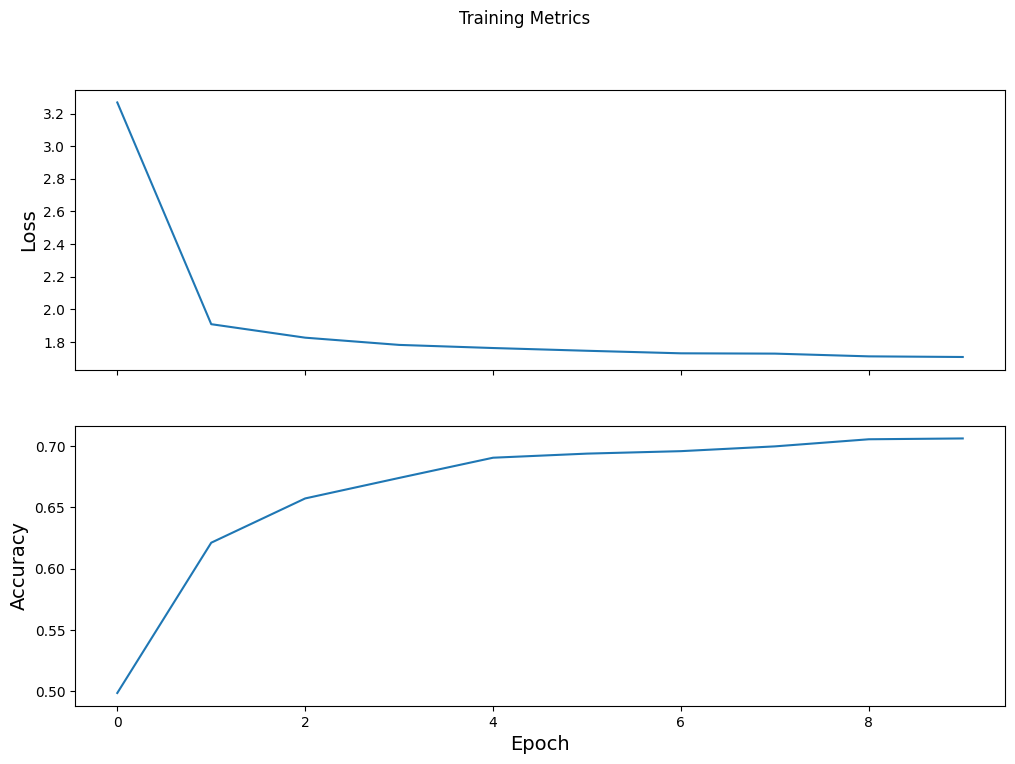

In [80]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [81]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: earn
     Label: earn


***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [82]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [83]:
# Initialize a new model
model = MyModel(64, 64, 46)


#### Redefine the grad function using the @tf.function decorator

In [91]:
# Use the @tf.function decorator

@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)


#### Train the model

In [92]:
# Re-run the training loop
from tensorflow.keras import utils
import time

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        epoch_loss_avg(loss_value)
        epoch_accuracy(y, model(x))

    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

print("Duration :{:.3f}".format(time.time() - start_time))


Epoch 000: Loss: 1.697, Accuracy: 70.730%
Epoch 001: Loss: 1.700, Accuracy: 70.853%
Epoch 002: Loss: 1.689, Accuracy: 71.031%
Epoch 003: Loss: 1.688, Accuracy: 71.131%
Epoch 004: Loss: 1.686, Accuracy: 71.120%
Epoch 005: Loss: 1.688, Accuracy: 71.476%
Epoch 006: Loss: 1.676, Accuracy: 71.242%
Epoch 007: Loss: 1.676, Accuracy: 71.421%
Epoch 008: Loss: 1.688, Accuracy: 71.176%
Epoch 009: Loss: 1.666, Accuracy: 71.910%
Duration :114.648


#### Print the autograph code

In [93]:
# Use tf.autograph.to_code to see the generated code
print(tf.autograph.to_code(grad.python_function))


def tf__grad(model, inputs, targets, wd):
    with ag__.FunctionScope('grad', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        with ag__.ld(tf).GradientTape() as tape:
            loss_value = ag__.converted_call(ag__.ld(loss), (ag__.ld(model), ag__.ld(inputs), ag__.ld(targets), ag__.ld(wd)), None, fscope)
        try:
            do_return = True
            retval_ = (ag__.ld(loss_value), ag__.converted_call(ag__.ld(tape).gradient, (ag__.ld(loss_value), ag__.ld(model).trainable_variables), None, fscope))
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

